# Building a stand-alone off-Wiki layered map using Wikidata & SPARQL

This Jupyter notebook shows you step by step **how to make an Wikidata-driven layered map that can be used off-Wiki**.

It is part of Module 3 of a [map making workshop](https://wikimania.wikimedia.org/wiki/2019:Libraries/Map_making_workshop_%E2%80%93_from_Wikidata_to_interactive_off-wiki_maps_in_three_steps) during Wikimania 2019, 18th August 2019, Stockholm, Sweden

See https://github.com/ookgezellig/WikidataMapMakingWorkshop/blob/master/OutlineAndNotes.md for the full layout of this workshop

To make the map we will use
1. **PAWS** (Jupyter Notebooks as a cloud service) - https://www.mediawiki.org/wiki/PAWS
2. **SPARQL queries** from Wikidata - https://www.wikidata.org + https://query.wikidata.org/
3. **ipyleaflet** (or Jupyter-Leaflet) : Interactive maps in the Jupyter notebook - https://github.com/jupyter-widgets/ipyleaflet + https://ipyleaflet.readthedocs.io/en/latest/
4. **ipywidgets** (or Jupyter-widgets) - https://github.com/jupyter-widgets/ipywidgets + https://ipywidgets.readthedocs.io/en/latest/
    
For questions about this notebook, contact [Olaf Janssen](https://www.wikidata.org/wiki/User:OlafJanssen) on Wikidata // olaf.janssen@kb.nl // https://twitter.com/ookgezellig


I assume that you have started your PAWS server (https://paws.wmflabs.org/paws/hub) and that you have uploaded the [raw json file *MapMakingWorkshop_Wikimania2019.ipynb*](https://paws-public.wmflabs.org/paws-public/User:OlafJanssen/MapMakingWorkshop_Wikimania2019.ipynb?format=raw) to it. We will use this as a starting point.

Check that the URL of this notebook is https://paws.wmflabs.org/paws/user/YOURUSERNAME/notebooks/MapMakingWorkshop_Wikimania2019.ipynb (unless you renamed the notebook of course)
    
OK, now run (the 5 commands in) the following cell. Alternatively, you can also open your PAWS terminal (https://paws.wmflabs.org/paws/user/YOURUSERNAME/terminals/1)
and run them there one by one, but omitting the leading '!'   



In [1]:
#To enable SPARQL  - https://rdflib.github.io/sparqlwrapper/
!pip install sparqlwrapper

#To enable iPYLeaflet  - https://ipyleaflet.readthedocs.io/en/latest/installation.html 
!pip install ipyleaflet
!jupyter nbextension enable --py --sys-prefix ipyleaflet

#To enable iPYWidgets - https://ipywidgets.readthedocs.io/en/stable/user_install.html 
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Next, run the cell below to import the necessary Python libraries 

In [2]:
# Import necessary Python libraries 

import json
import os
import requests
import pandas as pd

from ipyleaflet import *

from ipywidgets import *
from ipywidgets.embed import embed_minimal_html, dependency_state, embed_data

# https://python-visualization.github.io/branca/colormap.html#colormap
# https://jiffyclub.github.io/palettable/colorbrewer/diverging/
from branca.colormap import linear

Next we want to import data that is the result of a SPARQL query in Wikidata 

For this, we are using the query https://w.wiki/6gJ (public libraries in the Netherlands, an (as per 9-8-2019) incomplete data set)
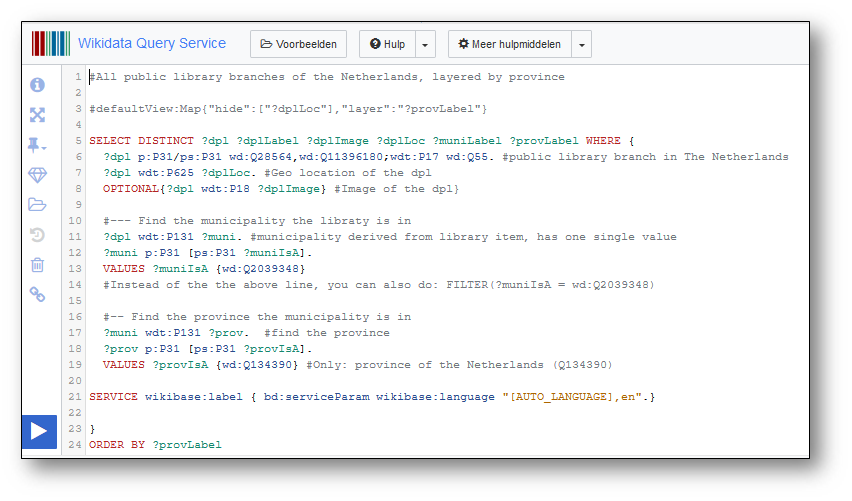    

Run this query, and under *</>Code --> Python* you will see the Python code that has been pasted in the cell below
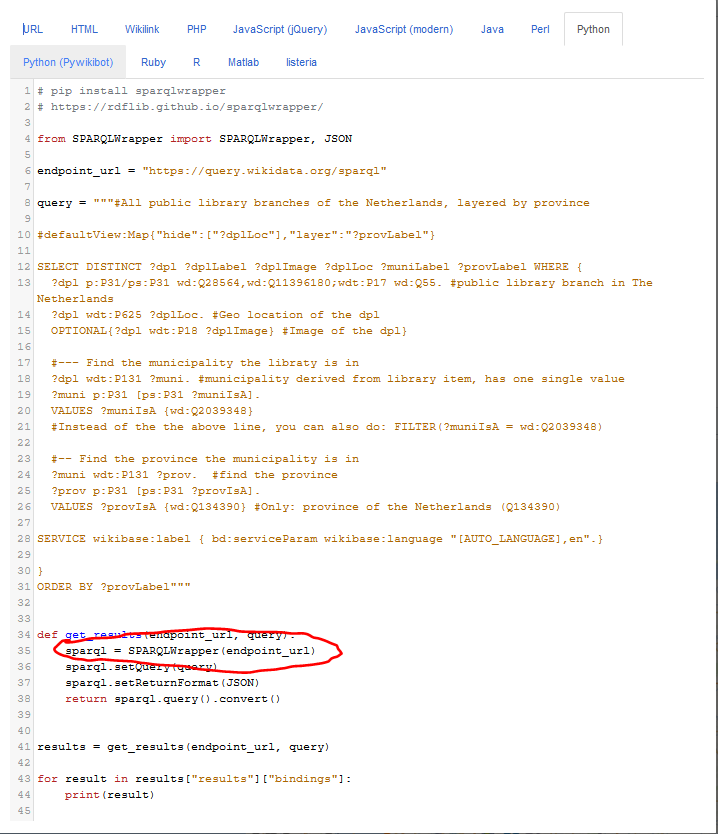

What about the red 'circle' in the screenshot above? To be able to run any SPARQL queries we must first set an explicit [User-Agent](https://meta.wikimedia.org/wiki/User-Agent_policy) to avoid getting blocked from the Wikidata Query Service - see
* https://lists.wikimedia.org/pipermail/wikidata/2019-July/013247.html
* https://phabricator.wikimedia.org/T230135
    
You do this by changing in the Python code the line

```python
sparql = SPARQLWrapper(endpoint_url)
```
by 
```python
sparql = SPARQLWrapper(endpoint_url, agent='User:YourUserName from PAWS notebook NotebookName.ipynb')
```
(and replace *YourUserName* with your real user name and *NotebookName* with the name of your notebook)

In [3]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """#All public library branches of the Netherlands, layered by province

#defaultView:Map{"hide":["?dplLoc"],"layer":"?provLabel"}

SELECT DISTINCT ?dpl ?dplLabel ?dplImage ?dplLoc ?muniLabel ?provLabel WHERE {
  ?dpl p:P31/ps:P31 wd:Q28564,wd:Q11396180;wdt:P17 wd:Q55. #public library branch in The Netherlands 
  ?dpl wdt:P625 ?dplLoc. #Geo location of the dpl
  OPTIONAL{?dpl wdt:P18 ?dplImage} #Image of the dpl} 
  
  #--- Find the municipality the libraty is in
  ?dpl wdt:P131 ?muni. #municipality derived from library item, has one single value
  ?muni p:P31 [ps:P31 ?muniIsA].
  VALUES ?muniIsA {wd:Q2039348}
  #Instead of the the above line, you can also do: FILTER(?muniIsA = wd:Q2039348) 
  
  #-- Find the province the municipality is in
  ?muni wdt:P131 ?prov.  #find the province
  ?prov p:P31 [ps:P31 ?provIsA].
  VALUES ?provIsA {wd:Q134390} #Only: province of the Netherlands (Q134390) 
  
SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".}  
 
}
ORDER BY ?provLabel"""


def get_results(endpoint_url, query):
    sparql = SPARQLWrapper(endpoint_url, agent='User:OlafJanssen from PAWS notebook MapMakingWorkshop_Wikimania2019.ipynb')
    #sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    print(result)

{'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q61764043'}, 'dplLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Assen public library'}, 'dplLoc': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': 'Point(6.558683 52.9946471)'}, 'muniLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Assen'}, 'provLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Drenthe'}}
{'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q61764051'}, 'dplLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Hoogeveen public library'}, 'dplLoc': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': 'Point(6.4800902 52.7291871)'}, 'muniLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Hoogeveen'}, 'provLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Drenthe'}}
{'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q61915762'}, 'dplLabel': {'xml:lang': 'en', 'type': 

{'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q60499452'}, 'dplLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Schellinkhout public library'}, 'dplLoc': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': 'Point(5.1219979 52.6344143)'}, 'muniLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Drechterland'}, 'provLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'North Holland'}}
{'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q60499461'}, 'dplLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Venhuizen public library'}, 'dplLoc': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': 'Point(5.19984 52.66342)'}, 'muniLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Drechterland'}, 'provLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'North Holland'}}
{'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q60499464'}, 'dplLabel': 

In order to make maps later on, we first need to do some transformation on the coordinates in the result of the cell above:

Convert coordinates *string tuple* like 'Point(6.558683 52.9946471)' into coordinates *float tuple* (52.9946471, 6.558683)

Note that the lat long order has been switched

In [7]:
#First make a new working copy of the original dict
results = get_results(endpoint_url, query)
libdict = results["results"]["bindings"]
#print(libdict) 

# Convert coordinates string tuple like 'Point(6.558683 52.9946471)' into coordinates float tuple (52.9946471, 6.558683)
# You will probably need to adapt the dictionary keys ['dplLoc']['value'] to match your own result set.

lib_coor_list=[]
for result in libdict:
    str_tuple = result['dplLoc']['value'][5:] #String tuple, strip the 'Point'-part
    #print(str_tuple)
    # See https://blender.stackexchange.com/questions/131827/converting-string-int-tuple-to-float-tuple
    float_tuple2 = tuple(float(s) for s in str_tuple.strip("()").split(" ")) 
    float_tuple = (float_tuple2[1],float_tuple2[0]) #reverse order of tuple elements
    result['dplLoc']['value'] = float_tuple #update dict
    lib_coor_list.append(float_tuple)


In [8]:
print(libdict)

[{'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q61764043'}, 'dplLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Assen public library'}, 'dplLoc': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': (52.9946471, 6.558683)}, 'muniLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Assen'}, 'provLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Drenthe'}}, {'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q61764051'}, 'dplLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Hoogeveen public library'}, 'dplLoc': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': (52.7291871, 6.4800902)}, 'muniLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Hoogeveen'}, 'provLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Drenthe'}}, {'dpl': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q61915762'}, 'dplLabel': {'xml:lang': 'en', 'type': 'literal'

In [9]:
print(lib_coor_list)

[(52.9946471, 6.558683), (52.7291871, 6.4800902), (52.8528604, 6.313289), (52.8348958, 6.3697596), (52.7738645, 6.2337536), (52.8575015, 6.206885), (53.139851, 6.4294479), (53.0671982, 6.4616009), (53.1484106, 6.4993715), (52.6715312, 6.4289521), (52.7587964, 6.3522069), (52.7235509, 6.2515855), (52.6767626, 6.2909147), (52.6778105, 6.488065), (52.8605795, 6.5127028), (52.9737389, 6.4800476), (52.945958, 6.4483896), (52.8483199, 6.6106635), (52.3712, 5.2206), (52.7107009, 5.746911), (52.3363865, 5.2186265), (52.3940622, 5.2766666), (52.3459733, 5.1511196), (52.4781819, 5.5015475), (52.5078979, 5.4747252), (52.5195892, 5.486443), (52.5088705, 5.4698154), (52.3308504, 5.5416925), (52.5236844, 5.7193634), (52.5713382, 5.6428296), (52.4566861, 5.6914176), (52.6640473, 5.6020868), (53.1044062, 6.0986522), (53.1928014, 5.9919202), (53.2135675, 5.9417194), (53.2411023, 5.8922686), (53.2001111, 5.8005258), (53.0890931, 5.8261502), (53.2631556, 5.7596027), (53.2001111, 5.8005258), (51.9675573, 

Now we have two data objects available to make a map with

1. *libdict*  (= a dictionary)
2. *lib_coor_list*  (= a list)

We can use them to start building a layered map step by step

First, we start with a simple basemap (see https://ipyleaflet.readthedocs.io/en/latest/api_reference/map.html)

Overview of basemaps: 
* https://leaflet-extras.github.io/leaflet-providers/preview/  
* https://github.com/jupyter-widgets/ipyleaflet/blob/master/ipyleaflet/basemaps.py

Note: not all basemaps seems to work equally well    

In [25]:
# Now that we have the data ready & loaded, we can start building a layered map step by step

# First, we start with a simple basemap of The Netherlands
basemap=basemaps.Esri.WorldTopoMap
default_layer = basemap_to_tiles(basemap)
default_layer.name='Base map of The Netherlands'

# Overview of more basemaps: https://leaflet-extras.github.io/leaflet-providers/preview/ + 
# https://github.com/jupyter-widgets/ipyleaflet/blob/master/ipyleaflet/basemaps.py

# Set initial center and zoom level of basemap
map_center=(52.088889, 5.33) #Utrecht city
map_zoom=8

# Set layout of map
map_layout = {
    'width': '800px',
    'height': '900px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}

# Output the map to screen, embedded in notebook
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/map.html
m = Map(layers=(default_layer,), center=map_center, zoom=map_zoom, layout=map_layout)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

 Next we add a dark layer to the map above

In [11]:
# Dark background, 'night theme'
dark_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
m.add_layer(dark_layer) 

Next we add a simple heatmap of public libraries in The Netherlands - https://ipyleaflet.readthedocs.io/en/latest/api_reference/heatmap.html

In [26]:
# Make a simple heatmap of Dutch public libraries - #https://ipyleaflet.readthedocs.io/en/latest/api_reference/heatmap.html

simple_heatmap = Heatmap(
    locations=lib_coor_list, # list of library coordinates, see cell above, 
                             # format is [(51.9617013, 5.8618218), (52.0039373, 5.9423836), (lat,long)....]
    max= 10,
    min_opacity= 0.5, 
    max_zoom =19, #If max_zoom value is small (6 o so..) the heatmap layer becomes untoggleable (can't be switched on/off, see cells below)
    radius = 7.0, 
    blur = 3.0, 
    gradient = {0.4: "blue", 0.6: "cyan", 0.7: "lime", 0.8: "yellow", 1.0: "red"},
    name = 'Simple heatmap public libraries'
)

m.add_layer(simple_heatmap) 

You will notice that in this simple heatmap the indivudual libraries are not clickable. 
Let's fix this. 
We want to add an (onClick) popup for every library in the heatmap, containing the municipality and province in which the library is situated.

As we can't directly add popus to a heatmap, we first need to make a circular marker for every library, to which we then connect a popup. 

* https://ipyleaflet.readthedocs.io/en/latest/api_reference/circle.html
* https://ipyleaflet.readthedocs.io/en/latest/api_reference/popup.html

In [13]:
# Next we want to add a (onClick) popup for every library in the heatmap, containing the municipality and province of the library
# As we can't directly add popus to a heatmap, we first need to make a circular marker for every library, 
# to which we then connect a popup. 

circlelist=[]

for result in libdict:
       
    #============================Popup contents, with HTML formatting==========================
    libname=result['dplLabel']['value'] #library name(label) in English
    muniname= '<b>Municipality:</b> ' + result['muniLabel']['value'] # municipality the library is in 
    provname='<b>Province:</b> ' + result['provLabel']['value'] # province the municipality is in 
    
    #===================POPUP TEMPLATE=======================================
    # This template determines the text layout in the popup. 
    # With the external css you can tweak the styling of the text. You might need to create this css yourself, 
    # or download it from https://paws-public.wmflabs.org/paws-public/User:OlafJanssen/popupstyle.css
    # and upload it to your own PAWS server
    
    # The approach with rendering the HTML template was found via 
    # https://ipywidgets.readthedocs.io/en/latest/embedding.html#python-interface
    lib_popup_template = """ 
    <!DOCTYPE html>
    <html>
      <head>
        <link rel='stylesheet' type='text/css' href='popupstyle.css'>
      </head>
      <body>
        <h4>{xlibname}</h4>
        <p>
        {xmuni}<br/>
        {xprov}
        </p>
      </body>
    </html>
    """
    #Connect the 3 names from libdict to the 3 {field}s in the HTML template  
    rendered_template = lib_popup_template.format(xlibname=libname, xmuni=muniname, xprov=provname)
    
    #https://ipyleaflet.readthedocs.io/en/latest/api_reference/popup.html
    message = HTML()
    message.value = rendered_template
    #message.description = popup_image
    #============================================================
    
    coor=result['dplLoc']['value'] #library coordinates, eg (53.0671982, 6.4616009)
    
    #https://ipyleaflet.readthedocs.io/en/latest/api_reference/circle.html
    circle = Circle(location=coor, radius=12, color="red", fill_color="red", opacity=0.005) #0.005 = hardly visible
    
    circlelist.append(circle)
    circle.popup = message # Bind popup to circle
    
# Create one layer(group) from all the circles + popups, using a LayerGroup
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/layer_group.html
lib_circles_popups = LayerGroup(layers=circlelist, name='Library info (click on marker')

Now we want to combine the three layers above 
1. simple_heatmap layer 
2. dark background layer 
3. circles popup layer

into one single layer - as per https://ipyleaflet.readthedocs.io/en/latest/api_reference/layer_group.html

In [21]:
# Group 3 layers (simple_heatmap, dark map style and circles-layer) into 1 overall layer
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/layer_group.html
heatmap_full= LayerGroup(layers=(simple_heatmap,dark_layer,lib_circles_popups), name='Heatmap public libraries (with popups)')

m.add_layer(heatmap_full)

The resulting map should look like this

!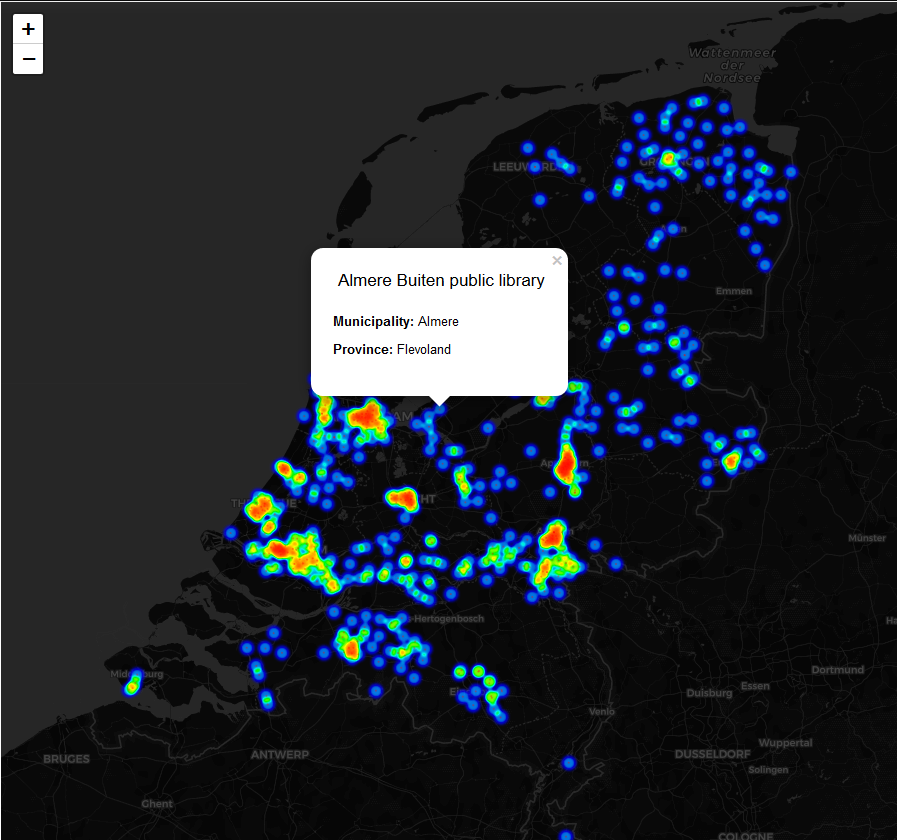
<br clear="all"/>
<small>(Note to self: you can use HTML in Markdown - https://stackoverflow.com/questions/14675913/changing-image-size-in-markdown)</small>

As a next step we want to make a layer displaying the boundaries of all municipalities in The Netherlands that have 
one or more public libraries, using GeoShapes, as [explained in Module 2](https://github.com/ookgezellig/WikidataMapMakingWorkshop/blob/master/OutlineAndNotes.md#module-26-geoshapes-using-sparql-and-osm) of the workshop.

To make this layer, we first need to requets GeoJson geoshapes (boundaries) from Wikidata Q-values. See
* https://phabricator.wikimedia.org/T138868
* https://maps.wikimedia.org/geoshape?getgeojson=1&ids=Q701,Q694
* https://maps.wikimedia.org/geoshape?getgeojson=1&query=SPARQLQuery 

We do this via [P131](https://www.wikidata.org/wiki/Property:P131), *Located in the administrative territorial entity* = municipality where the library is located

In the cell below, the SPARQL query after ```nl_muni_url = "https://maps.wikimedia.org/geoshape?getgeojson=1&query=``` is (the encoded version) of 

```
SELECT DISTINCT ?id WHERE {
      ?item p:P31/ps:P31 wd:Q28564,wd:Q11396180;wdt:P17 wd:Q55. #Public library branch in the Netherlands
      ?item wdt:P131 ?id. 
      ?id p:P31 [ps:P31 ?idIsA].
      VALUES ?idIsA {wd:Q2039348}. #filter only the values 'municipality of the Netherlands' Q2039348 
    }
```
Note that ```?id``` *must have* this name!

In [15]:
# As a next step we want to make a layer displaying the boundaries of all municipalities in The Netherlands that have 
# public libraries, using GeoShapes, as explained in Module 2 of the workshop (https://etherpad.wikimedia.org/p/wm2019-mapmakingworkshop)

# To make this layer, we first need to requets GeoJson GeoShapes (boundaries) from Wikidata Q-values. See
# https://phabricator.wikimedia.org/T138868
# https://maps.wikimedia.org/geoshape?getgeojson=1&ids=Q701,Q694
# https://maps.wikimedia.org/geoshape?getgeojson=1&query=<SPARQL> 

# We do this via P131, 'located in the administrative territorial entity' = municipality where the library is located

localgeojsonfile='nl_munis_with_public_libs.json' #This (cache) file is generated once if it does not yet exist. 
# Remove it from the server to generate a fresh/new version
# This code was taken from https://ipyleaflet.readthedocs.io/en/latest/api_reference/geo_json.html

if not os.path.exists(localgeojsonfile):
  nl_muni_url = "https://maps.wikimedia.org/geoshape?getgeojson=1&query=SELECT%20DISTINCT%20%3Fid%20WHERE%20%7B%0A%20%20%20%20%20%20%3Fitem%20p%3AP31%2Fps%3AP31%20wd%3AQ28564%2Cwd%3AQ11396180%3Bwdt%3AP17%20wd%3AQ55.%20%23Public%20library%20branch%20in%20the%20Netherlands%0A%20%20%20%20%20%20%3Fitem%20wdt%3AP131%20%3Fid.%20%0A%20%20%20%20%20%20%3Fid%20p%3AP31%20%5Bps%3AP31%20%3FidIsA%5D.%0A%20%20%20%20%20%20VALUES%20%3FidIsA%20%7Bwd%3AQ2039348%7D.%20%23filter%20only%20the%20values%20'municipality%20of%20the%20Netherlands'%20Q2039348%20%0A%20%20%20%20%7D"
  r = requests.get(nl_muni_url)
  with open(localgeojsonfile, 'w') as f:
    f.write(r.content.decode("utf-8"))

with open(localgeojsonfile, 'r') as f:
  muni_geoshapes = json.load(f)


Now that we have the GeoJson object (muni_geoshapes), we can build a map layer with it

https://ipyleaflet.readthedocs.io/en/latest/api_reference/geo_json.html

In [22]:
# Now make a layer with above boundaries (GeoShapes)

# Choose styling of layer
muni_style={'color': 'red', 'opacity':1, 'weight':1, 'dashArray':'2', 'fillOpacity':0.2, 'fillColor':'blue'}

# 'muni_geoshapes' is GeoJson-object taken from cell above
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/geo_json.html
muni_boundaries = GeoJSON(data=muni_geoshapes, style=muni_style, name='Municipal boundaries',hover_style={'fillOpacity': 0.5})

m.add_layer(muni_boundaries)

The resulting map should look like this (zoomed in, focus on the red municipal boundaries, no popup showing)

!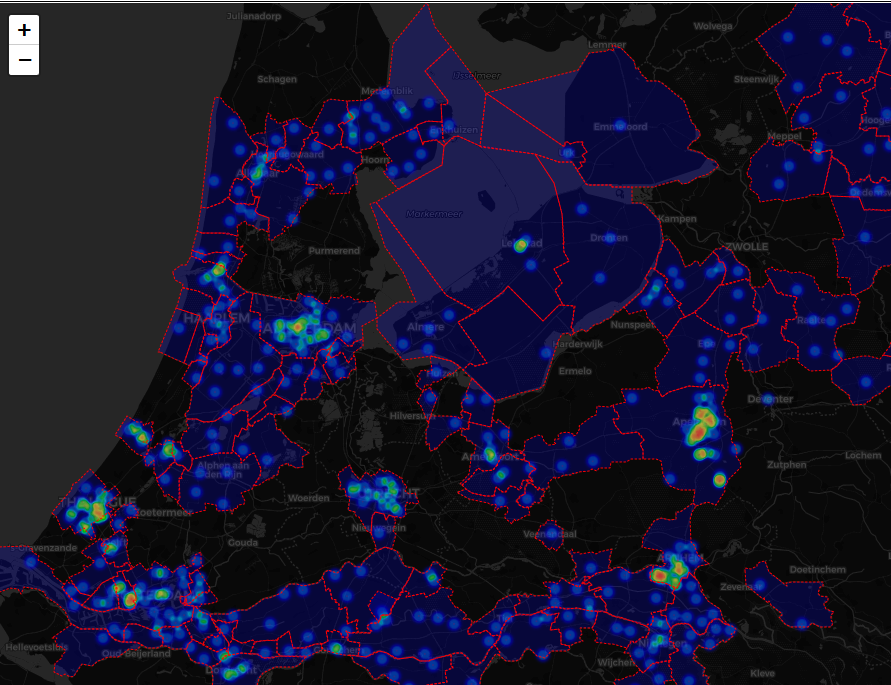
<br clear="all"/>

We have added a number of layers to the map. We can add a control in the top right corner of the map to switch layers on and off.

We also add a Fullscreen control

* https://ipyleaflet.readthedocs.io/en/latest/api_reference/fullscreen_control.html
* https://ipyleaflet.readthedocs.io/en/latest/api_reference/layers_control.html

In [23]:
# Add Layers and Fullscreen controls
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/fullscreen_control.html
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/layers_control.html

m.add_control(LayersControl()) 
m.add_control(FullScreenControl()) 

The resulting heatmap looks like this, with the red municipal geoshapes, a popup, a layers control and a fullscreen control

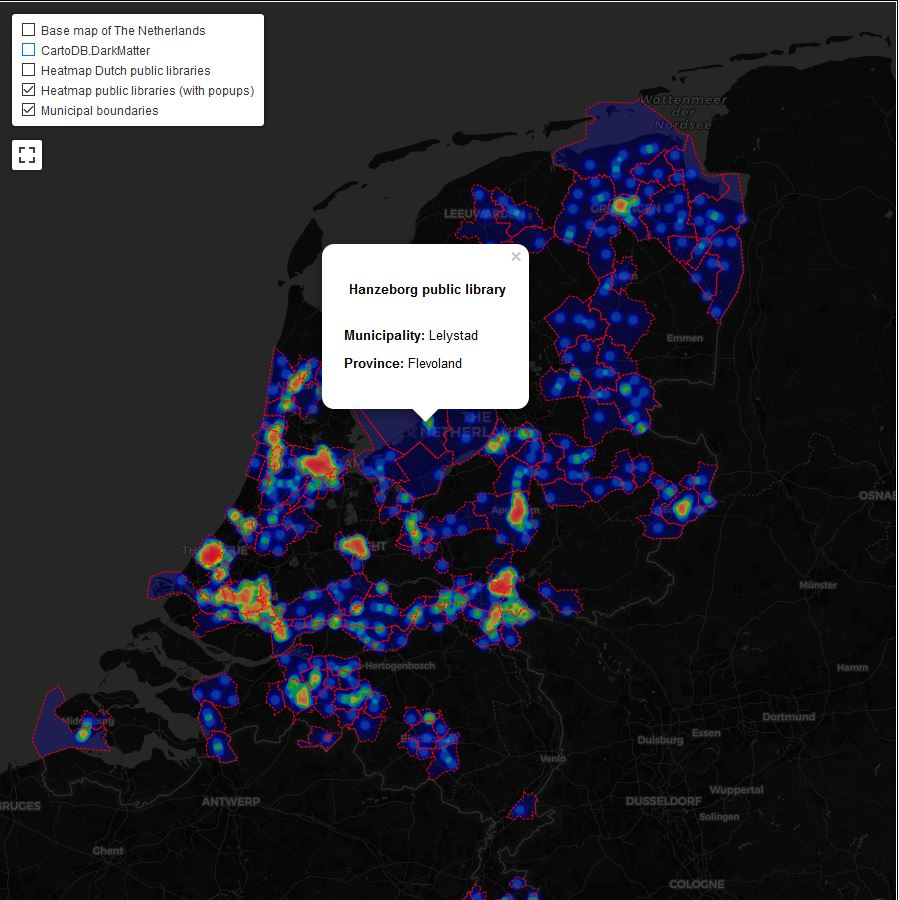

As a final step for this workshop, we want to export the map to a (stand-alone, off-Wiki) HTML page that can be viewed in a browser.

https://ipywidgets.readthedocs.io/en/latest/embedding.html#python-interface    

In [19]:
# Export the map to html file
# https://ipywidgets.readthedocs.io/en/latest/embedding.html#python-interface
# The addition of 'state=dependency_state([m])' keeps the html file growing too large

embed_minimal_html('NetherlandsPublicLibrariesHeatmap.html', views=[m], state=dependency_state([m]), title='Heat map of Dutch public libraries, Wikimania map making workshop, 18th August 2019')

# This is the end of the notebook for the Wikimania workshop on 18 Aug 2019

## Reusing this notebook
You are free to reuse this notebook, it is available under the license [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)

![CC-BY-SA logo](https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/CC-BY-SA.svg/200px-CC-BY-SA.svg.png)

## The cells below contain additional code (snippets) that can be used as inspiration for building additional map features.

### There is no guarantee that all the (perhaps sometimes messy or outdated) code will run smoothly, you might need to do some tweaking

In [ ]:
# Next, we want to request the library density for every municipality = number of public libraries per 10.000 inhabitants
# As output format we need a dictionary:
# lib_density_dict = {'key':float_value, ...} = {'WDQ':density_float, ...}, eg. {'Q745038':0.6379, ....}

# You could do this via an URL-query : https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=<SPARQL>&format=json
# (taken from https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/nl), 
# but we don't do that here, we instead use the "def get_results(endpoint_url, query):" from the cell above, 
# as this makes the (somewhat complex) SPARQL query more explicit/visible 

# TODO: Get most recent municipal population figures from CBS and add those to Wikidata

density_query = """SELECT 
?id ?lib_count ?pop ?pop_year ?lib_density
WHERE { 

  { #-- start subquery to get number of libraries in each municipality
    SELECT ?muni (COUNT(?muni) AS ?lib_count) WHERE {
      ?item p:P31/ps:P31 wd:Q28564,wd:Q11396180;wdt:P17 wd:Q55.
      ?item wdt:P131 ?muni.
      ?muni p:P31 [ps:P31 ?muniIsA].
      VALUES ?muniIsA {wd:Q2039348}. #filter only the value 'municipality of the Netherlands' Q2039348 
      ?muni rdfs:label ?muniLabel.
      FILTER (lang(?muniLabel) = 'nl') 
      
    } #where
    GROUP BY ?muni  
 }   #-- end subquery  
   
#main query 
   BIND(?muni AS ?id)
   
   OPTIONAL{
    ?muni p:P1082 ?popStatement.
    ?popStatement ps:P1082 ?pop;
                  pq:P585 ?pop_date .
    BIND(STR(YEAR(?pop_date)) AS ?pop_year).
    } #optional
  
   #https://stackoverflow.com/questions/49066390/how-to-get-only-the-most-recent-value-from-a-wikidata-property
   FILTER NOT EXISTS {
    ?muni p:P1082/pq:P585 ?helpdate .
    FILTER (?helpdate > ?pop_date)
    BIND(STR(YEAR(?pop_date)) AS ?pop_year).
    }
    BIND(IF(BOUND(?pop),(10000*?lib_count/?pop),'N/A') AS ?lib_density)
 }"""


localdensityfile='nl_public_library_density.json' #remove this file from the server to generate a fresh/new version
if not os.path.exists(localdensityfile):
    density_results = get_results(endpoint_url, density_query)

    # Transform density_results into lib_density_dict = {'key':float_value, ...} = 
    # {'WDQ':density_float, ...}, eg. {'Q745038':0.6379, ....} 
    lib_density_dict ={}
    for dr in density_results["results"]["bindings"]:
        #print(dr)
        wdq=dr['id']['value'].split("/")[-1:][0]
        lib_density=dr['lib_density']['value']
        if lib_density != 'N/A':
            lib_density_dict[wdq] = float(lib_density)
        else:
            lib_density_dict[wdq] = 0.0
    print(lib_density_dict) 
    with open(localdensityfile, 'w') as f:
        json.dump(lib_density_dict, f, indent=4)

#print(density_results)    

with open(localdensityfile, 'r') as g:
    lib_density_dict = json.load(g)
    #print(lib_density_dict)

In [ ]:
# We can now combine the 'muni_geoshapes' and the 'lib_density_dict' data to make a Colorpleth 
# to show municipal library density (per 10.000 inhabitants) on a map.
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/choropleth.html

density_style={'color': 'red', 'opacity':1, 'weight':1, 'dashArray':'2', 'fillOpacity':0.2}
libdensitylayer = Choropleth(
    geo_data=muni_geoshapes, #geojson dict "id":"key" - eg. "id":"Q745038" (Waalwijk)
    choro_data=lib_density_dict , #simple dict of "key":float 
    #e.g. "Q745038":0.6379992344009187189 --> generated from SPARQL query in the cell above
    colormap=linear.RdYlGn_11, #https://jiffyclub.github.io/palettable/colorbrewer/sequential/#ylgnbu_3
    style=density_style,
    #value_min =0.0,
    #value_max = 3.0,
    hover_style={'fillOpacity': 0.7},
    name='Gemeentelijke bibliotheekdichtheid, per inwoner')

#m.add_layer(libdensitylayer)

In [ ]:
# Now we want to make a layer that displays an infobox containing municipal data:
# 1) Name of municipality (in Dutch) - still to sparql
# 2) Province the municiplaity is in 
# 3) No of inhabitatns (in a given year)
# 4) Area in km^2 (in a given year) - still to sparql
# 5) No of libraries in the municiplaity
# 6) Library density - per 10.000 inhabitants
# 7) Library density - per km^2 - still to calculate

boxlayout=Layout(margin='0 0 0 0px', 
                 border='2px dashed white', 
                 width='auto')
label = HTML()

box=Box([label], layout=boxlayout)

#print(layer.style.keys)

def hover_handler(event=None, id=None, properties=None):
    label.value="<b style='color:white'>Gemeente:</b><br/><br/><br/><br/>"

    #label.value="<b>Gemeente:</b> "+ #properties['geounit']+\
    #"<br/><b>Provincie:</b> "+ #properties['subregion']+\
    #"<br/><b>Inwoners:</b> "+ #str('{:,}'.format(properties['pop_est']).replace(',', '.'))+\
    #"<br/><b>Inkomen:</b> "+ #str('{:,}'.format(properties['gdp_md_est']).replace(',', '.'))    
    
libdensitylayer.on_hover(hover_handler)

#m.add_layer(muni_boundaries)

widget_control = WidgetControl(widget=box, position='bottomright', min_height=115, max_height=115, 
                               min_width=250)
m.add_control(widget_control)

In [ ]:
# Optional gadget: add small minimap into the main map
minimap = Map(
    zoom_control=False, attribution_control=False, center=center, basemap=basemap, continuous_update=False)
minimap.layout.width = '200px'
minimap.layout.height = '200px'
minimap.zoom=zoom+2
#minimap.add_layer(bibliotheekvestigingen)
link((minimap, 'center'), (m, 'center'))
#link((minimap, 'zoom'), (m, 'zoom'))

minimap_control = WidgetControl(widget=minimap, position='bottomleft')
m.add_control(minimap_control)